In [1]:
## Import packages
import pandas as pd
import matplotlib.pyplot as plt
from geolite2 import geolite2
import pycountry
import country_converter as coco
import geopandas as gpd
import os
import mapclassify
import descartes
import numpy as np
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,TruncatedSVD



In [2]:

## Change the display format of Pandas to suppress scientific notation of large/small numbers
pd.options.display.float_format = '{:.5f}'.format


colnames = ["Timestamp", "IP_Address", "Port"]
df = pd.read_csv('360data.csv', names = colnames)

In [3]:
## Check for missing values
print(df.isna().sum())
df.dtypes

Timestamp     0
IP_Address    1
Port          1
dtype: int64


Timestamp      object
IP_Address     object
Port          float64
dtype: object

In [4]:
## Find the beginning of our timeseries
df.sort_values('Timestamp').head(3)



,Timestamp,IP_Address,Port
0,2016-08-02 00:03:09,189.103.205.162,23.00000
1,2016-08-02 00:03:37,92.253.101.15,23.00000
2,2016-08-02 00:04:48,187.37.225.63,23.00000


In [5]:
## Find the end of our timeseries
df.sort_values('Timestamp').tail(3)




,Timestamp,IP_Address,Port
5947141,2017-01-24 23:59:54,188.212.195.162,6789.00000
5947142,2017-01-24 23:59:58,222.180.240.41,23.00000
3613590,22016-11-16 00:00:01,59.127.84.56,2323.00000


In [6]:
# Finding the index of an invalid datapoint
df.index[df['Timestamp'] == '2016-12-29 17:37:#']

Int64Index([5309424], dtype='int64')

In [7]:
#Cleaning some invalid datapoints
df.iloc[3613590, df.columns.get_loc('Timestamp')] = '2016-11-16 00:00:01'
df.iloc[5309424, df.columns.get_loc('Timestamp')] = '2016-12-29 17:37:00'

In [8]:
#Transform our timeseries to a datetime datatype
df['Timestamp'] = pd.to_datetime(df.Timestamp, infer_datetime_format=True)
    

In [9]:
#Saving just the date and month in a new variable for plotting purposes 
df['date'] = df.Timestamp.map(lambda x: x.strftime('%Y-%m-%d'))

In [10]:
#Checking the unique values of the ports in our dataset
df.Port.unique()

array([2.3000e+01, 2.3230e+03, 7.5470e+03, 5.5550e+03, 3.7777e+04,
       2.3231e+04, 6.7890e+03,        nan])

In [11]:
#Check the amount of unique IP Addresses in the dataset 
df['IP_Address'].unique

<bound method Series.unique of 0          189.103.205.162
1            92.253.101.15
2            187.37.225.63
3          113.162.242.131
4             190.3.202.69
5            189.62.230.66
6          190.147.187.164
7          191.189.247.187
8          113.182.206.172
9            200.6.249.116
10          189.78.215.192
11          14.175.161.108
12           94.190.92.213
13         174.134.187.160
14         179.104.132.118
15         181.175.130.198
16         115.211.232.154
17            31.24.204.99
18           88.247.30.132
19           189.82.102.66
20          14.191.197.222
21          187.36.189.254
22           189.29.32.119
23           190.56.240.18
24          223.29.207.130
25          14.167.210.198
26            177.6.195.37
27         186.214.247.248
28           91.197.220.42
29            1.53.204.222
                ...       
5947113         5.36.95.14
5947114     122.116.96.241
5947115      83.228.92.198
5947116       14.134.66.41
5947117       42.118.56.

In [12]:
# Convert the IP address to a string

df['IP_Address'] = df.IP_Address.astype(str)

In [13]:
# Check the datatypes
df.dtypes

Timestamp     datetime64[ns]
IP_Address            object
Port                 float64
date                  object
dtype: object

In [14]:
# Convert the IP address to the iso country code and save as a new variable
geo = geolite2.reader()

def get_country(ip):
    try:
        x = geo.get(ip)
    except ValueError:
        return pd.np.nan
    try:
        return x['country']['names']['en'] if x else pd.np.nan
    except KeyError:
        return pd.np.nan

df['country'] = df.IP_Address.apply(get_country)


In [15]:
df.head()

,Timestamp,IP_Address,Port,date,country
0,2016-08-02 00:03:09,189.103.205.162,23.00000,2016-08-02,Brazil
1,2016-08-02 00:03:37,92.253.101.15,23.00000,2016-08-02,Hashemite Kingdom of Jordan
2,2016-08-02 00:04:48,187.37.225.63,23.00000,2016-08-02,Brazil
3,2016-08-02 00:09:17,113.162.242.131,23.00000,2016-08-02,Vietnam
4,2016-08-02 00:09:52,190.3.202.69,23.00000,2016-08-02,Colombia


In [16]:
df.columns = ['Timestamp', 'IP_Address', 'Port', 'date',  'Country']

In [17]:
df.head()

,Timestamp,IP_Address,Port,date,Country
0,2016-08-02 00:03:09,189.103.205.162,23.00000,2016-08-02,Brazil
1,2016-08-02 00:03:37,92.253.101.15,23.00000,2016-08-02,Hashemite Kingdom of Jordan
2,2016-08-02 00:04:48,187.37.225.63,23.00000,2016-08-02,Brazil
3,2016-08-02 00:09:17,113.162.242.131,23.00000,2016-08-02,Vietnam
4,2016-08-02 00:09:52,190.3.202.69,23.00000,2016-08-02,Colombia


In [18]:
## Count the total amount of new infections for each country and save it in a new dataframe
infect = df.Country.value_counts()
infect = infect.to_frame()
infect.reset_index(level=0, inplace=True)
infect.columns = ['Country', 'Infections']





In [19]:
## Define conversion function
def conversion(x):
    y = coco.convert(names = x, to = 'ISO3')
    return y

In [20]:
## Import population data
popdata = pd.read_excel('populatie.xls')

## Get names of indexes for which column Pouplation has a value lower than 300000
indexNames = popdata[ popdata['Population'] < 300000 ].index
 
## Delete these row indexes from popdata
popdata.drop(indexNames , inplace=True)





In [21]:
## Apply function to infections dataframe
infect['Country_Code'] = infect.Country.apply(conversion)

## Check
infect
    

/anaconda3/lib/python3.7/site-packages/country_converter/country_converter.py:412: FutureWarning: read_table is deprecated, use read_csv instead.
  for str_col in must_be_string})


,Country,Infections,Country_Code
0,China,1222710,CHN
1,Taiwan,680392,TWN
2,Vietnam,631832,VNM
3,Brazil,501957,BRA
4,Republic of Korea,378055,KOR
5,Russia,224737,RUS
6,Turkey,206934,TUR
7,Ukraine,200446,UKR
8,India,183535,IND
9,United States,152411,USA


In [22]:
## Merge the infections dataframe with the population dataframe
inf = infect.merge(popdata, left_on = 'Country_Code', right_on = 'Country_Code')

## Check
inf.head()


,Country,Infections,Country_Code,Country_Name,Population
0,China,1222710,CHN,China,1392730000.00000
1,Vietnam,631832,VNM,Vietnam,95540395.00000
2,Brazil,501957,BRA,Brazil,209469333.00000
3,Republic of Korea,378055,KOR,"Korea, Rep.",51635256.00000
4,Russia,224737,RUS,Russian Federation,144478050.00000


In [23]:
## Merge the infections dataframe with the population dataframe
inf = infect.merge(popdata, left_on = 'Country_Code', right_on = 'Country_Code')

## Make a new variable that describes infection rate
inf['Infection_Rate'] = (inf.Infections / inf.Population) * 100

## delete unnecessary columns
del inf['Country']
del inf['Infections']
del inf['Population']

## Check
inf.head()





,Country_Code,Country_Name,Infection_Rate
0,CHN,China,0.08779
1,VNM,Vietnam,0.66132
2,BRA,Brazil,0.23963
3,KOR,"Korea, Rep.",0.73216
4,RUS,Russian Federation,0.15555


Text(0.5, 0, 'Infection Rate (%)')

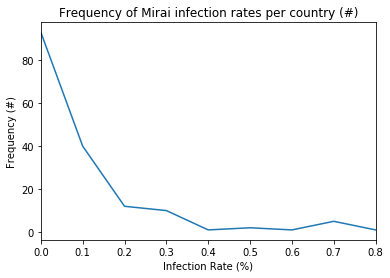

In [24]:
## edit the data for plotting purposes
inf['RInfection_Rate'] = inf.Infection_Rate.round(1)
a = inf['RInfection_Rate'].value_counts()
a = pd.DataFrame(a)
a = a.reset_index()
a.columns = ['Infection_Rate', 'frequency']
a = a.sort_values('Infection_Rate')
ax = a.plot(x ='Infection_Rate', y = 'frequency', legend = False, title = "Frequency of Mirai infection rates per country (#)" )
ax.set_ylabel("Frequency (#)")
ax.set_xlabel("Infection Rate (%)")


In [25]:
## importing shapefile
shapefile = os.path.expanduser('ne_10m_admin_0_countries_lakes.shp')
geo = gpd.read_file(shapefile)[['ADM0_A3', 'geometry']].to_crs('+proj=robin')

# Get names of index of Antarctica 
indexNames = geo[ geo['ADM0_A3'] == 'ATA' ].index

# Delete the index of Antarctica
geo.drop(indexNames , inplace=True)

## Merge the shapefile dataframe with our infections dataframe
geoinfect = geo.merge(inf, left_on = 'ADM0_A3', right_on = 'Country_Code', how = 'left')

## Delete unnecessary column
del geoinfect['ADM0_A3']

## Check
geoinfect




,geometry,Country_Code,Country_Name,Infection_Rate,RInfection_Rate
0,"MULTIPOLYGON (((11108970.260 445285.130, 11108...",IDN,Indonesia,0.01616,0.00000
1,"MULTIPOLYGON (((11108970.260 445285.130, 11108...",MYS,Malaysia,0.08723,0.10000
2,"MULTIPOLYGON (((-6477059.899 -1872360.838, -64...",CHL,Chile,0.23171,0.20000
3,"POLYGON ((-6477059.899 -1872360.838, -6477072....",BOL,Bolivia,0.09867,0.10000
4,"MULTIPOLYGON (((-6477059.899 -1872360.838, -64...",PER,Peru,0.01045,0.00000
5,"MULTIPOLYGON (((-5516294.069 -5568444.259, -55...",ARG,Argentina,0.20047,0.20000
6,"POLYGON ((3008931.293 3740791.337, 3007063.917...",NaN,NaN,nan,nan
7,"MULTIPOLYGON (((3009012.519 3740778.293, 30089...",CYP,Cyprus,0.06845,0.10000
8,"MULTIPOLYGON (((6915098.813 3796247.587, 69170...",IND,India,0.01357,0.00000
9,"MULTIPOLYGON (((7341533.511 3229629.092, 73418...",CHN,China,0.08779,0.10000


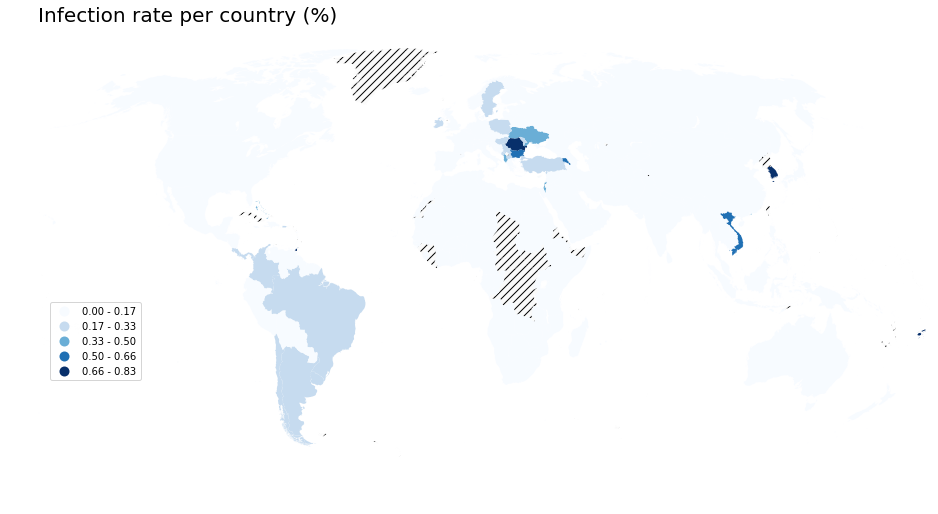

In [26]:
## Plot the infection rate per country on a chloropleth map using Geopandas

## Some plot settings

colors = 5
cmap = 'Blues'
figsize = (16, 10)
plotvar = 'Infection_Rate'
scheme = 'equalinterval'
title = 'Infection rate per country (%)'
    
## plot

ax = geoinfect.dropna().plot(plotvar, cmap=cmap, figsize=figsize, scheme=scheme, k=colors, legend=True)
geoinfect[geoinfect.isna().any(axis=1)].plot(ax=ax, color='#fafafa', hatch='///')
ax.set_title(title, fontdict={'fontsize': 20}, loc='left')
ax.set_axis_off()
ax.set_xlim([-1.5e7, 1.7e7])
ax.get_legend().set_bbox_to_anchor((.12, .4))
fig = ax.get_figure()
fig.savefig("output.png")



In [27]:
## Remove missing values
geoinfect = geoinfect.dropna()

In [28]:
## Import the GCI data
GCI = pd.read_excel('GCIdata.xlsx')

##Check
GCI

,Country,GCI
0,Singapore,0.92500
1,United States of America,0.91900
2,Malaysia,0.89300
3,Oman,0.87100
4,Estonia,0.84600
5,Mauritius,0.83000
6,Australia,0.82400
7,Georgia,0.81900
8,France,0.81900
9,Canada,0.81800


In [29]:
## Convert the country in CGI data to ISO3 country code
GCI['Country_Code'] = GCI.Country.apply(conversion)

## Delete the country name
del GCI['Country']

#Check if every name is converted correctly
GCI

/anaconda3/lib/python3.7/site-packages/country_converter/country_converter.py:412: FutureWarning: read_table is deprecated, use read_csv instead.
  for str_col in must_be_string})


,GCI,Country_Code
0,0.92500,SGP
1,0.91900,USA
2,0.89300,MYS
3,0.87100,OMN
4,0.84600,EST
5,0.83000,MUS
6,0.82400,AUS
7,0.81900,GEO
8,0.81900,FRA
9,0.81800,CAN


In [30]:
##Drop the missing values from the geoinfect df

## Merge the GCI data with the geoinfections dataset 
geoinfect1 = geoinfect.merge(GCI, left_on = 'Country_Code', right_on = 'Country_Code', how = 'left')

## Check
geoinfect1

,geometry,Country_Code,Country_Name,Infection_Rate,RInfection_Rate,GCI
0,"MULTIPOLYGON (((11108970.260 445285.130, 11108...",IDN,Indonesia,0.01616,0.00000,0.42400
1,"MULTIPOLYGON (((11108970.260 445285.130, 11108...",MYS,Malaysia,0.08723,0.10000,0.89300
2,"MULTIPOLYGON (((-6477059.899 -1872360.838, -64...",CHL,Chile,0.23171,0.20000,0.36700
3,"POLYGON ((-6477059.899 -1872360.838, -6477072....",BOL,Bolivia,0.09867,0.10000,0.12200
4,"MULTIPOLYGON (((-6477059.899 -1872360.838, -64...",PER,Peru,0.01045,0.00000,0.37400
5,"MULTIPOLYGON (((-5516294.069 -5568444.259, -55...",ARG,Argentina,0.20047,0.20000,0.48200
6,"MULTIPOLYGON (((3009012.519 3740778.293, 30089...",CYP,Cyprus,0.06845,0.10000,0.48700
7,"MULTIPOLYGON (((6915098.813 3796247.587, 69170...",IND,India,0.01357,0.00000,0.68300
8,"MULTIPOLYGON (((7341533.511 3229629.092, 73418...",CHN,China,0.08779,0.10000,0.62400
9,"POLYGON ((3093872.093 3338162.433, 3095187.213...",ISR,Israel,0.46449,0.50000,0.69100


In [31]:
## Import the GDP data
GDP = pd.read_excel('GDPdata.xlsx')

## Convert country names to ISO 3
GDP['Country_Code'] = GDP.Country.apply(conversion)

## Manually add the country codes for Congo, Rep., Northern Marina Islands, Virgin Islands, and Channel Islands

GDP.loc[GDP.Country == 'Northern Marina Islands', 'Country_Code'] = 'MNP'
GDP.loc[GDP.Country == 'Congo, Rep.', 'Country_Code' ] =  'COG'
GDP.loc[GDP.Country == 'Virgin Islands', 'Country_Code'] = 'VIR'
        
## Delete Channel Islands
GDP = GDP.drop(GDP[GDP.Country  == 'Channel islands'].index)
        
#Check
GDP.head()
        

,Country,GDP,Country_Code
0,Afghanistan,520.90000,AFG
1,Albania,5253.60000,ALB
2,Algeria,4278.90000,DZA
3,American Samoa,11398.80000,ASM
4,Andorra,42029.80000,AND


In [32]:
## Merge the GDP data with the geoinfections data
geoinfect2 = geoinfect1.merge(GDP, left_on = 'Country_Code', right_on = 'Country_Code', how = 'left')

## Delete unnecessary columns
del geoinfect2['Country'] 
del geoinfect2 ['geometry']

## Check
geoinfect2.head()

,Country_Code,Country_Name,Infection_Rate,RInfection_Rate,GCI,GDP
0,IDN,Indonesia,0.01616,0.00000,0.42400,3893.60000
1,MYS,Malaysia,0.08723,0.10000,0.89300,11239.00000
2,CHL,Chile,0.23171,0.20000,0.36700,15923.40000
3,BOL,Bolivia,0.09867,0.10000,0.12200,3548.60000
4,PER,Peru,0.01045,0.00000,0.37400,6947.30000


In [33]:
## Import Computer Science Papers data
cspapers = pd.read_excel('cspapers.xlsx')

## check
cspapers.head()

,Country,Documents
0,United States,1121016
1,China,967476
2,Germany,312619
3,United Kingdom,286678
4,Japan,284604


In [34]:
## Import total papers data
papers = pd.read_excel('totalpapers.xlsx')

## Check
papers.head()

,Country,Documents
0,United States,12070144
1,China,5901404
2,United Kingdom,3449243
3,Germany,3019959
4,Japan,2750108


In [35]:
## Merge both datasets
rscp= papers.merge(cspapers, left_on = 'Country', right_on = 'Country', how = 'left')

## Rename columns
rscp.columns = ['Country', 'CS_Papers', 'Total_Papers']

## Fill the missing values with zeros
rscp.fillna(0, inplace = True)

## Calculate the RSCP
rscp['RSCP'] = rscp.Total_Papers / rscp.CS_Papers

## convert the country name to the ISO 3 country code
rscp ['Country_Code'] = rscp.Country.apply(conversion)

## Manually input the ISO 3 code for the Netherlands Antilles
rscp.loc[rscp.Country == 'Netherlands Antilles', 'Country_Code'] = 'ANT'

## Delete unnessecary columns\
del rscp['Country']
del rscp['CS_Papers']
del rscp['Total_Papers']

## Check
rscp.head()

,RSCP,Country_Code
0,0.09288,USA
1,0.16394,CHN
2,0.08311,GBR
3,0.10352,DEU
4,0.10349,JPN


In [36]:
## Merge the RSCP data with the geoinfections data
geoinfect3 = geoinfect2.merge(rscp, left_on = 'Country_Code', right_on = 'Country_Code', how ='left')

#Check
geoinfect3.isna().sum()

Country_Code       0
Country_Name       0
Infection_Rate     0
RInfection_Rate    0
GCI                3
GDP                1
RSCP               0
dtype: int64

In [37]:
## Read ICT Development Index data
IDI = pd.read_excel('IDI.xlsx')

## Convert Country names to ISO 3 codes
IDI['Country_Code'] = IDI.Country.apply(conversion)

#Manually insert ISO 3 name for S, Tome & Principe
IDI.loc[IDI.Country == 'S,Tomé & Principe', 'Country_Code' ] = 'STP'

#Check
IDI 

,Country,IDI,Country_Code
0,Iceland,8.98000,ISL
1,"Korea, Rep,",8.85000,KOR
2,Switzerland,8.74000,CHE
3,Denmark,8.71000,DNK
4,United Kingdom,8.65000,GBR
5,"HongKong, China",8.61000,HKG
6,Netherlands,8.49000,NLD
7,Norway,8.47000,NOR
8,Luxembourg,8.47000,LUX
9,Japan,8.43000,JPN


In [38]:
## Merge the IDI data with the geoinfections data
geoinfect4 = geoinfect3.merge(IDI, left_on = 'Country_Code', right_on = 'Country_Code', how = 'left')

#Delete unnecessary column
del geoinfect4['Country']

## Check
geoinfect4.head()



,Country_Code,Country_Name,Infection_Rate,RInfection_Rate,GCI,GDP,RSCP,IDI
0,IDN,Indonesia,0.01616,0.00000,0.42400,3893.60000,0.17457,4.33000
1,MYS,Malaysia,0.08723,0.10000,0.89300,11239.00000,0.18192,6.38000
2,CHL,Chile,0.23171,0.20000,0.36700,15923.40000,0.07968,6.57000
3,BOL,Bolivia,0.09867,0.10000,0.12200,3548.60000,0.02091,4.31000
4,PER,Peru,0.01045,0.00000,0.37400,6947.30000,0.06943,4.85000


In [39]:
## Import the technology index data
TI = pd.read_excel('TI.xlsx')

## Convert the country names to ISO 3 code
TI['Country_Code'] = TI.Country.apply(conversion)

## Check
TI.head()

,Country,TI,Country_Code
0,United States,6.24000,USA
1,Taiwan,6.04000,TWN
2,Finland,5.92000,FIN
3,Sweden,5.80000,SWE
4,Japan,5.68000,JPN


In [40]:
## merge Technology Index data with the geoinfections data
geoinfect5 = geoinfect4.merge(TI, left_on = 'Country_Code', right_on = 'Country_Code')

## delete unnecessary column
del geoinfect5 ['Country']
del geoinfect5 ['RInfection_Rate']


## Scale the GDP values to ensure that parameters are comparable
geoinfect5['GDP'] = geoinfect5.GDP / 10000

## Check
geoinfect5.head()

,Country_Code,Country_Name,Infection_Rate,GCI,GDP,RSCP,IDI,TI
0,IDN,Indonesia,0.01616,0.42400,0.38936,0.17457,4.33000,3.31000
1,MYS,Malaysia,0.08723,0.89300,1.12390,0.18192,6.38000,4.67000
2,CHL,Chile,0.23171,0.36700,1.59234,0.07968,6.57000,4.55000
3,BOL,Bolivia,0.09867,0.12200,0.35486,0.02091,4.31000,2.81000
4,PER,Peru,0.01045,0.37400,0.69473,0.06943,4.85000,3.45000


In [41]:
## Import the GDI data
GDIdata = pd.read_excel('GDI.xlsx')

## Check
GDIdata.head()

,CountryCode,SNS
0,AFG,12.03964
1,ALB,144.64026
2,DZA,7.61996
3,ASM,179.40116
4,AND,2833.22768


In [42]:
# Merge the GDI data with the geoinfections data
geoinfect6 = geoinfect5.merge(GDIdata, left_on = 'Country_Code', right_on = 'CountryCode')

# Delete unnecessary columns
del geoinfect6['CountryCode']

# Check
geoinfect6.head()

,Country_Code,Country_Name,Infection_Rate,GCI,GDP,RSCP,IDI,TI,SNS
0,IDN,Indonesia,0.01616,0.42400,0.38936,0.17457,4.33000,3.31000,306.22331
1,MYS,Malaysia,0.08723,0.89300,1.12390,0.18192,6.38000,4.67000,945.64723
2,CHL,Chile,0.23171,0.36700,1.59234,0.07968,6.57000,4.55000,1237.18578
3,BOL,Bolivia,0.09867,0.12200,0.35486,0.02091,4.31000,2.81000,37.89042
4,PER,Peru,0.01045,0.37400,0.69473,0.06943,4.85000,3.45000,72.52789


In [43]:
# Define columns to be removed for factor correlations
columns = ['Country_Code', 'Country_Name', 'Infection_Rate']


# Create a new  geoinfections df without the Infection Rate and country code/name for factor correlations
corr = geoinfect6.drop(columns, axis = 1)

# Display correlations between factors 
corr.corr().to_excel('correlations.xlsx')


In [44]:
## Remove missing values
geoinfect6 = geoinfect6.dropna()



## Define independent/dependent variables
X = geoinfect6[[  "GDP", "IDI", "GCI"]]
y = geoinfect6['Infection_Rate']

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Infection_Rate   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     22.77
Date:                Mon, 18 Nov 2019   Prob (F-statistic):           3.64e-11
Time:                        10:27:46   Log-Likelihood:                 50.944
No. Observations:                  97   AIC:                            -95.89
Df Residuals:                      94   BIC:                            -88.16
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GDP           -0.0245      0.008     -2.937      0.004      -0.041      -0.008
IDI            0.0428      0.009      4.859      0.000       0.025       0.060
GCI           -0.1702      0.086     -1.977      0.051      -0.341       0.001
==============================================================================
Omnibus:                       70.030   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              301.858
Skew:                           2.534   Prob(JB):                     2.83e-66
Kurtosis:                      10.001   Cond. No.                         39.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

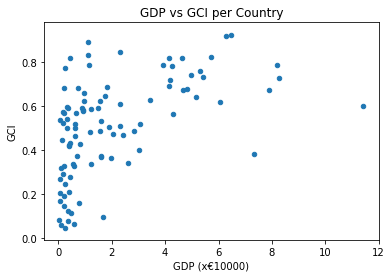

In [45]:
# Scatter plot GDP vs GCI
x = geoinfect6.plot.scatter(x = 'GDP', y = 'GCI', title = 'GDP vs GCI per Country')
x.set_xlabel('GDP (x€10000)')
plt.savefig('GCIGDP.png')

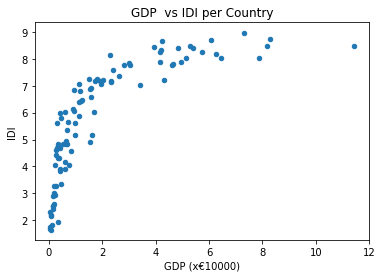

In [46]:
# Scatter plot GDP vs IDI
x = geoinfect6.plot.scatter(x = 'GDP', y = 'IDI', title = 'GDP  vs IDI per Country')
x.set_xlabel('GDP (x€10000)')
plt.savefig('IDIGDP.png')

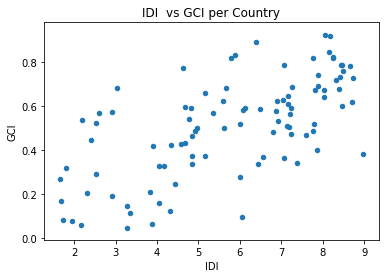

In [47]:
# Scatter plot IDI vs GCI 
geoinfect6.plot.scatter(x = 'IDI', y = 'GCI', title = 'IDI  vs GCI per Country')
plt.savefig('GCIIDI.png')